In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
cd ../src/

/home/theo/kaggle/nfl_impact/src


## Imports

In [3]:
import os
import re
import cv2
import time
import json
import torch
import imageio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
from skimage.transform import resize

from sklearn.metrics import roc_auc_score, f1_score

In [4]:
from params import *
from utils.plot import plot_confusion_matrix, visualize_preds
from utils.post_processing import post_process_adjacency, post_process_view, post_process_view_2
from utils.metrics import boxes_f1_score, precision_calc, get_boxes_from_df

## Load

In [5]:
PREDS_PATH = OUT_DIR + '21_12/'
os.listdir(PREDS_PATH)

['submission_wo_pp_score_85_epoch_12_fold(retrain, overfit).csv',
 'pred_0_fold_epoch_10.csv',
 'valid_0_fold.csv',
 'pred_0_fold_epoch_12.csv',
 'submission_wo_pp_score_85_epoch_10_best_score.csv',
 'pred_0_fold_epoch_11_score_04.csv',
 'pred_0_fold_epoch_11.csv',
 'pred_0_fold_epoch_9.csv']

In [6]:
df_train = pd.read_csv(DATA_PATH + 'df_train.csv')
folds = pd.read_csv(OUT_DIR + "folds.csv")
df_train = df_train.merge(folds, on="video")
df_train['truth'] = (df_train['impact'] == 1) & (df_train['confidence'] > 1) & (df_train['visibility'] > 0) 


df_val = df_train[df_train["val_idx"] == 0]

In [7]:
videos = df_val['video'].unique()

In [8]:
epoch = 11
preds = pd.read_csv(PREDS_PATH + f"pred_0_fold_epoch_{epoch}_score_04.csv")

### Params

In [99]:
# Probability thresholding
THRESHOLD_PRED = 0.8

# Adjacency post-processing
NMS_THRESHOLD = 0.35
THRESHOLD_IOU = 0.35
MAX_DIST = 4
MIN_CLUST_SIZE = 0

# View post-processing
MIN_DIST = 6

# Impact post-processing
MAX_FRAME_DIST = 10

## Score

In [10]:
def get_boxes_and_scores_from_df(df, videos):
    try:
        cols = ["frame", "video", "x", "w", "y", "h", "pred"]
        df = df[cols].groupby("video").agg(list)
    except KeyError:
        cols = ["frame", "video", "left", "width", "top", "height", "pred"]
        df = df[cols].groupby("video").agg(list)

    boxes = []
    scores = []

    for video in videos:
        try:
            frames, x, w, y, h, score = df.loc[video]
            boxes_pred = np.concatenate([
                np.array(frames)[:, None],
                np.array(x)[:, None],
                np.array(y)[:, None],
                np.array(w)[:, None] + np.array(x)[:, None],
                np.array(h)[:, None] + np.array(y)[:, None],
            ], -1)
            boxes.append(boxes_pred)
            scores.append(score)
        except KeyError:
            boxes.append([])
            scores.append([])
    return boxes, scores

In [11]:
pred_val = preds[preds['pred'] > THRESHOLD_PRED].reset_index(drop=True)

In [12]:
# scores = pred_val.groupby('video').agg(list)['pred'][videos].tolist()

In [13]:
gt_boxes = get_boxes_from_df(df_val[df_val['truth'] == 1], videos)
pred_boxes, scores = get_boxes_and_scores_from_df(pred_val, videos)

In [14]:
score = boxes_f1_score(pred_boxes, gt_boxes)

print(f' -> CV score is {score:.4f}')

 -> CV score is 0.1258


### NMS

In [15]:
from utils.post_processing import nms

In [16]:
nms_boxes = []
for boxes, score in zip(pred_boxes, scores):
    keep = nms(boxes[:, [1, 2, 3, 4, 0]], np.array(score), threshold=NMS_THRESHOLD)
#     print()
    nms_boxes.append(boxes[keep])
    
score = boxes_f1_score(nms_boxes, gt_boxes)

print(f' -> CV score is {score:.4f}')

 -> CV score is 0.1970


### Post-processing

In [17]:
df_pred_pp = pred_val.copy()

In [18]:
df_pred_pp = post_process_adjacency(
    df_pred_pp,
    threshold=THRESHOLD_IOU,
    max_dist=MAX_DIST,
    min_clust_size=MIN_CLUST_SIZE,
)

100%|██████████| 24/24 [00:10<00:00,  2.20it/s]


In [19]:
pred_boxes_pp = get_boxes_from_df(df_pred_pp, videos)
score = boxes_f1_score(pred_boxes_pp, gt_boxes)

print(f' -> CV score is {score:.4f}')

 -> CV score is 0.3177


## Classifier inference

### Data

In [20]:
import os
import cv2
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from data.transforms import get_transfos_cls
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset

In [21]:
def extend_box(box, size=64):
    w = box[1] - box[0]
    h = box[3] - box[2]
    
    dw = (size - w) / 2
    dh = (size - h) / 2
    
    new_box = [box[0] - np.floor(dw), box[1] + np.ceil(dw), box[2] - np.floor(dh), box[3] + np.ceil(dh)]
    return np.array(new_box).astype(int)

In [22]:
def adapt_to_shape(box, shape):
    if box[0] < 0:
        box[1] -= box[0]
        box[0] = 0
    elif box[1] >= shape[1]:
        diff = box[1] - shape[1]
        box[1] -= diff
        box[0] -= diff
        
    if box[2] < 0:
        box[3] -= box[2]
        box[2] = 0

    elif box[3] >= shape[0]:
        diff = box[3] - shape[0]
        box[3] -= diff
        box[2] -= diff
    
    return box

In [23]:
class NFLDatasetClsInference(Dataset):
    def __init__(self, df, transforms=None, root=""):
        super().__init__()
        self.transforms = transforms
        self.root = root
        
        self.images = np.unique(df['image_name'].values)
        self.images = [cv2.imread(self.root + img) for img in self.images]
        
        self.frame_to_img = list(np.unique(df['frame'].values))
        self.frames = df['frame'].values
        
        self.boxes = df[['left', 'width', 'top', 'height']].values
        self.boxes[:, 1] += self.boxes[:, 0]
        self.boxes[:, 3] += self.boxes[:, 2]
        
    def __len__(self):
        return len(self.boxes)

    def __getitem__(self, idx):
        frame = self.frame_to_img.index(self.frames[idx])
        image = self.images[frame]
        
        box = extend_box(self.boxes[idx], size=64)
        box = adapt_to_shape(box, image.shape)
        
        image = image[box[2] : box[3], box[0] : box[1]]

        if self.transforms:
            image = self.transforms(image=image)["image"]

        return image

In [24]:
df_pred = preds.copy()

In [25]:
df_pred['image_name'] = (df_pred['video'].str.replace('.mp4', '') + '_' +
                              df_pred['frame'].apply(lambda x: f'{x:04d}') + '.png')

In [26]:
df_pred_vid = df_pred[df_pred["video"] == df_pred['video'].unique()[1]]

dataset = NFLDatasetClsInference(
    df_pred_vid,
    transforms=get_transfos_cls(train=False, visualize=True),
    root=IMG_PATH_F,
)

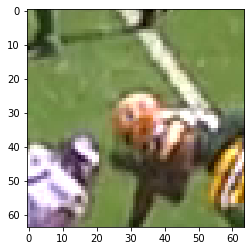

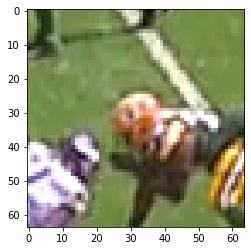

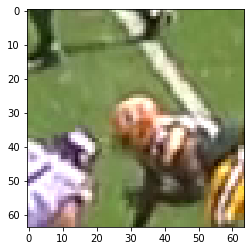

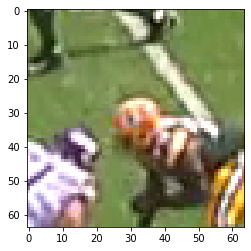

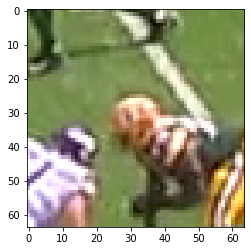

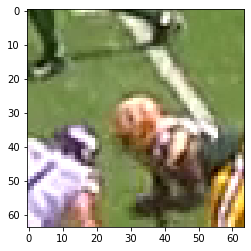

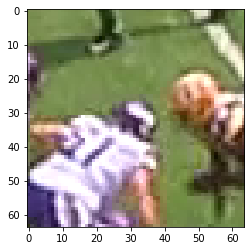

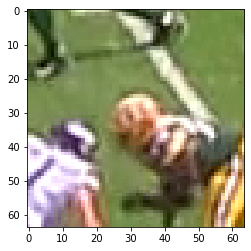

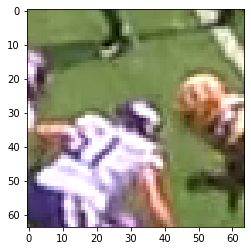

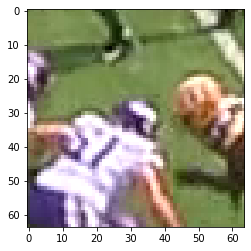

In [27]:
for i in range(10):
    plt.imshow(dataset[i].numpy().transpose(1, 2, 0))
    plt.show()

### Models

In [28]:
from model_zoo.models_cls import RESNETS
from utils.torch import load_model_weights

def get_model_cls(
    name, num_classes=1,
):
    """
    Loads a pretrained model.
    Supports Resnet based models.

    Args:
        name (str): Model name
        num_classes (int, optional): Number of classes. Defaults to 1.

    Raises:
        NotImplementedError: Specified model name is not supported.

    Returns:
        torch model -- Pretrained model.
    """

    # Load pretrained model
    if "resnest" in name:
        model = getattr(resnest_torch, name)(pretrained=False)
    elif name in RESNETS:
        model = getattr(torchvision.models, name)(pretrained=False)
    elif "efficientnet" in name:
        model = EfficientNet.from_name(name)
    else:
        raise NotImplementedError
    model.name = name

    if "efficientnet" not in name:
        model.conv1.stride = (1, 1)

        model.nb_ft = model.fc.in_features
        model.fc = nn.Linear(model.nb_ft, num_classes)

    else:
        model._conv_stem.stride = (1, 1)

        model.nb_ft = model._fc.in_features
        model._fc = nn.Linear(model.nb_ft, num_classes)

    model.num_classes = num_classes

    return model

In [29]:
def retrieve_model(config, fold=0, log_folder=""):
    model = get_model_cls(
        config['name'],
        num_classes=config['num_classes'],
    ).eval()
    model.zero_grad()

    model = load_model_weights(
        model,
        log_folder + f"{config['name']}_{fold}.pt"
    )

    return model

In [30]:
def inference(df, models, batch_size=256, device="cuda", root=""):
    models = [model.to(device).eval() for model in models]

    dataset = dataset = NFLDatasetClsInference(
        df.copy(),
        transforms=get_transfos_cls(train=False),
        root=root,
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    preds = []
    with torch.no_grad():
        for img in loader:
            img = img.to(device)
            preds_img = []
            
            for model in models:
                y_pred = model(img)
                preds_img.append(y_pred.sigmoid().detach().cpu().numpy())
                
            preds.append(np.mean(preds_img, 0))
            
    return np.concatenate(preds)

### Main

In [31]:
images = df_pred["image_name"].unique()

In [32]:
CP_FOLDER = "../dataset/"

In [33]:
configs = {
    "efficientnet-b3": {
        "name": "efficientnet-b3",
        "num_classes": 1,
        "k": 5,
    },
    "efficientnet-b1": {
        "name": "efficientnet-b1",
        "num_classes": 1,
        "k": 5,
    },
    "resnet18": {
        "name": "resnet18",
        "num_classes": 1,
        "k": 5,
    },
}

In [34]:
models = []
for model in configs:
    models += [retrieve_model(configs[model], fold=0, log_folder=CP_FOLDER)]


 -> Loading weights from ../dataset/efficientnet-b3_0.pt


 -> Loading weights from ../dataset/efficientnet-b1_0.pt


 -> Loading weights from ../dataset/resnet18_0.pt



In [35]:
preds = []
for vid in tqdm(df_pred['video'].unique()):
    df_pred_vid = df_pred[df_pred["video"] == vid]

    pred = inference(df_pred_vid, models, root=IMG_PATH_F)
    preds.append(pred)

In [36]:
df_pred['pred_cls'] = np.concatenate(preds)

## Results

In [45]:
THRESHOLD_DET = 0.65
THRESHOLD_CLS = 0.5
MIN_CLUST_SIZE = 0
THRESHOLD_IOU = 0.35
MAX_DIST = 4

In [46]:
df_pred_pp = df_pred.copy()

In [47]:
df_pred_pp = df_pred_pp[df_pred_pp['pred'] > THRESHOLD_DET]

In [48]:
df_pred_pp = df_pred_pp[df_pred_pp['pred_cls'] > THRESHOLD_CLS]

In [49]:
pred_boxes_pp = get_boxes_from_df(df_pred_pp, videos)
score = boxes_f1_score(pred_boxes_pp, gt_boxes)

print(f' -> CV score is {score:.4f}')

 -> CV score is 0.1910


### Box expansion

In [50]:
r = 0.1

# Expansion
df_pred_pp.left -= df_pred_pp.width * r / 2
df_pred_pp.top -= df_pred_pp.height * r / 2
df_pred_pp.width *= 1 + r
df_pred_pp.height *= 1 + r
df_pred_pp.left = np.clip(df_pred_pp.left, 0, None)
df_pred_pp.top = np.clip(df_pred_pp.top, 0, None)
df_pred_pp.width = np.clip(df_pred_pp.width, 0, 1280 - df_pred_pp.left)
df_pred_pp.height = np.clip(df_pred_pp.height, 0, 720 - df_pred_pp.top)

# Rounding 

right = np.round(df_pred_pp.left + df_pred_pp.width, 0)
bot = np.round(df_pred_pp.top + df_pred_pp.height, 0)
df_pred_pp.left = np.round(df_pred_pp.left, 0).astype(int)
df_pred_pp.top = np.round(df_pred_pp.top, 0).astype(int)

df_pred_pp.width = (right - df_pred_pp.left).astype(int)
df_pred_pp.height = (bot - df_pred_pp.top).astype(int)

### Post-processing

In [70]:
df_pred_pp = post_process_adjacency(
    df_pred_pp,
    threshold=THRESHOLD_IOU,
    max_dist=MAX_DIST,
    min_clust_size=MIN_CLUST_SIZE,
)

100%|██████████| 24/24 [00:00<00:00, 82.00it/s]


In [71]:
pred_boxes_pp = get_boxes_from_df(df_pred_pp, videos)
score = boxes_f1_score(pred_boxes_pp, gt_boxes)

print(f' -> CV score is {score:.4f}')

 -> CV score is 0.3918


### View pp

In [100]:
df_pred_pp_view = post_process_view(df_pred_pp, min_dist=MIN_DIST)

100%|██████████| 12/12 [00:00<00:00, 21.84it/s]


In [101]:
pred_boxes_pp = get_boxes_from_df(df_pred_pp_view, videos)
score = boxes_f1_score(pred_boxes_pp, gt_boxes)

print(f' -> CV score is {score:.4f}')

 -> CV score is 0.4201
